# Time series forecasting example1
In this example we will look at forecasting future temperature from historic weather data.
The data is obtained from: https://www.southamptonweather.co.uk/wxtempsummary.php

For time-series-forecasting, the below steps should be followed:

get data

-- check for to see if stationary

-- if not apply transformations

-- set d equal to number of times series differenced (for ARIMA or SARIMA)

-- list values of p and q

-- fit every combination of ARIMA (p,d,q) or SARIMA (p,d,q)

-- select model with lowest AIC

-- residual analysis

check:

-- q-q plot shows straight line

-- uncorrelated residuals

then ready for forecasts

In [1]:
# Load the required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import xlsxwriter as xlw
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Get data

In [2]:
# setup
file_name = 'C:\\Users\\kelvi\\Desktop\\southampton_wxr.xlsx' # train/test on existing data

#open file
df = pd.read_excel(file_name)#, skiprows=4,sheet_name='test')

#rename col of interest to 'test'
df.rename(columns={'temp':'test'},inplace=True) # here we are looking at / predicting temp (or temperature)

# make date as df index...?
# df.set_index('date')

# Check to see if it is stationary

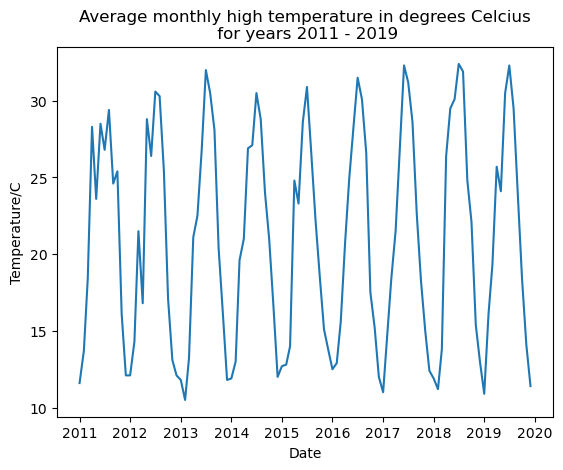

In [3]:
# plot the data
fig, ax = plt.subplots()

ax.plot(df.date, df.test)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.set_title("Average monthly high temperature in degrees Celcius\n for years 2011 - 2019");

In [4]:
# check if it is stationary

# perform dickey-fuller test
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df.test, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.311328
p-value                         0.168340
#Lags Used                     10.000000
Number of Observations Used    97.000000
Critical Value (1%)            -3.499637
Critical Value (5%)            -2.891831
Critical Value (10%)           -2.582928
dtype: float64


The test statistic is larger than (most of) the critical values and the p-value is larger than 0.05 so we cannot reject the null hypothesis and conclude the data is not stationary

# Apply data transformations if needed

In [5]:
# Try first order differencing to see if this makes the data stationary

data_diff = np.diff(df.test, n=1) # n is the number of differencing terms

# repeat the dickey-fuller test

# perform dickey-fuller test
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(data_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.144568e+01
p-value                        6.027061e-21
#Lags Used                     9.000000e+00
Number of Observations Used    9.700000e+01
Critical Value (1%)           -3.499637e+00
Critical Value (5%)           -2.891831e+00
Critical Value (10%)          -2.582928e+00
dtype: float64


Now the test statistic and the p-value are less than the critical values and threshold of 0.05 respectively. Now we can conclude that the series is stationary and accept the alternate hypothesis, and can reject the null hypothesis that the series is non-stationary.

# Set d equal to the number of differences (integration)

In [6]:
d = 1 # if the differencing is repeated e.g. 2 or 3 times then d would need to be 2 or 3 respectively

# List values of p and q

In [7]:
# set a range of values to try for p and q
# d is a constant which is set to the number of differencing terms (integration)

p_try = range(0,4,1) # increment in +1 steps
q_try = range(0,4,1)

values_try = []

for i in p_try:
    for j in q_try:
        values_try.append([i,j])
        
values_try_df = pd.DataFrame(values_try)
values_try_df.columns = ['p','q']
print(values_try_df)

    p  q
0   0  0
1   0  1
2   0  2
3   0  3
4   1  0
5   1  1
6   1  2
7   1  3
8   2  0
9   2  1
10  2  2
11  2  3
12  3  0
13  3  1
14  3  2
15  3  3


# Train and test split the data

In [8]:
# because the differencing (integration) term d is used, we do not need to manipulate the dataframe data

train = df.test[:-4] # all data points except the last 4
test = df.test.iloc[-4:] # from 4 data points before the end of the datapoints, to the end of the datapoints

# Fit every combination of p,d,q

In [9]:
# we have already set the value of d above, which is constant for this exercise
results = []
for eacher in range(0,len(values_try_df),1):
    # for each p and q value fit the model
    try:
        model = ARIMA(train, order=(values_try_df['p'][eacher],d,values_try_df['q'][eacher])).fit()
    except:
        continue
        
    # record the results
    aic = model.aic
    results.append([values_try_df['p'][eacher],values_try_df['q'][eacher],aic])
    
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
    
# sort in descending order by aic score, as lower aic is better
results_df = results_df.sort_values(by='aic', ascending=True).reset_index(drop=True)

print(results_df)

    p  q         aic
0   2  3  473.351238
1   3  3  475.261250
2   3  2  494.381386
3   2  2  530.792920
4   3  1  535.323571
5   1  2  582.868942
6   1  3  583.975685
7   0  2  585.577483
8   3  0  585.917333
9   2  0  589.698825
10  2  1  589.753230
11  1  1  595.692927
12  0  3  595.948543
13  1  0  596.211216
14  0  1  599.750734
15  0  0  603.083024


# Select model with lowest AIC (Akaike information criterion)

The AIC is a measure of the quality of a given model relative to the other models. The AIC is a way of quantifying the information loss of a model when fitted to data, and determining which model has the lowest amount of information lost - hence having a lower AIC score. The lowest scoring AIC model is therefore the best performing model to use.

In [10]:
# select lowest aic score p and q value
p_use = results_df['p'][0]
q_use = results_df['q'][0]

print(f"the value of p to use is: {p_use}")
print(f"the value of q to use is: {q_use}")
print(f"the lowest model aic is: {results_df['aic'][0]}")

# fit the model
model = ARIMA(train,order=(p_use,d,q_use))
model_fit = model.fit()

the value of p to use is: 2
the value of q to use is: 3
the lowest model aic is: 473.3512379793419


# Residual analysis

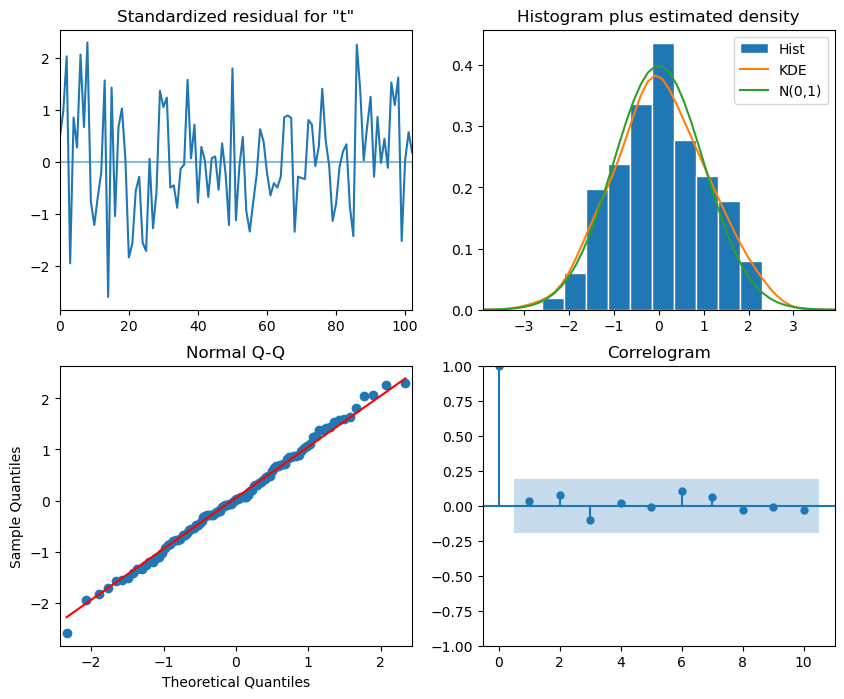

In [11]:
# check the dianostics and see if the plots are appropiate
model_fit.plot_diagnostics(figsize=(10,8));

# Check the plot diagnositics

# Standardized residual
The standard residual chart shows no apparent trend, and the mean seems fairly constant which implies that the residuals are likely stationary.

# Histogram
The histogram plot shows a shape similar to a normal distribution.

# Q-Q Plot
The datapoints on the quartile-quartile plot approximately lie straight (on the red, 45 degree line). This means that our data is normally distributed. If the data were not normally distributed, the datapoints would deviate from the reference, 45 degree red line.

# Correlogram
The autocorrelation plot shows no autocorrelation/significant variance after lag 0

# Conclusion
These plot diagnostics indicate that the residuals resemble random fluctuations (white noise), and so we can conclude that the residuals are normally distributed and uncorrelated.

# Check uncorrelated residuals

In [12]:
# perform a Ljung - box test on the residuals and check the p-value
residuals = model_fit.resid

ttt = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)#np.arange(1, 11, 1))

print(ttt.lb_pvalue)

1     0.893550
2     0.324085
3     0.516766
4     0.603068
5     0.716025
6     0.583127
7     0.351964
8     0.451812
9     0.477767
10    0.492015
Name: lb_pvalue, dtype: float64


As the p-values are all greater than 0.05, we can accept the null hypothesis and conclude that the residuals are uncorrelated.

Now that we are happy the model has passed all of these checks, we can move on to forecasting.

# Forecast!

In [13]:
# forecast the test data split, and compare to a naive approach (repeating the previous 4 datapoints)

# actual data
test = df.iloc[-4:]

# naive approach
test['naive'] = df.test.iloc[len(df)-8:len(df)-4].values # the prior 4 datapoints to the last 4 datapoints (repeat previous data)

# ARIMA predictions
ARIMA_preds = model_fit.get_prediction(len(df)-4,len(df)).predicted_mean

test['arima_pred'] = ARIMA_preds

Graph the results

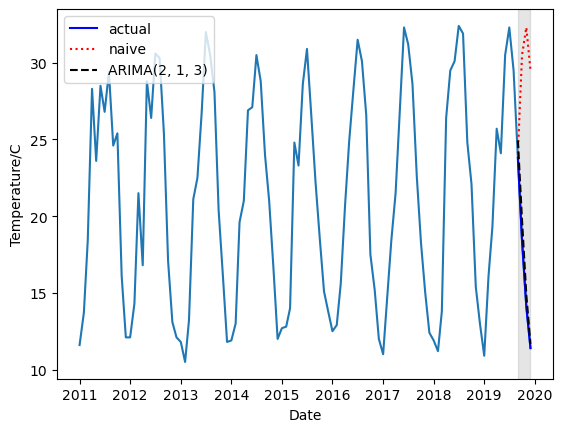

In [14]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['test'])
ax.plot(test['date'], test['test'], 'b-', label='actual')
ax.plot(test['date'], test['naive'], 'r:', label='naive')
ax.plot(test['date'], test['arima_pred'], 'k--', label=f"ARIMA{p_use,d,q_use}")

ax.set_xlabel('Date')
ax.set_ylabel('Temperature/C')
ax.axvspan(df.date[len(df)-4],df.date[len(df)-1], color='#808080', alpha=0.2)

ax.legend(loc=2);

# Quantify the error on the test data

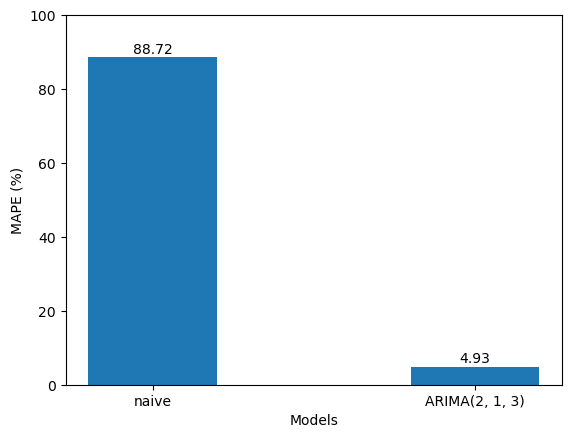

In [15]:
# We can quantify the mean absolute percentage error (MAPE) by comparing the real value to the predicted value

def mape_value (true_value, predicted_value):
    return np.mean(np.abs((true_value - predicted_value) / true_value)) * 100

naive_mape = mape_value(test['test'],test['naive'])
arima_mape = mape_value(test['test'],test['arima_pred'])

# graph this
fig, ax = plt.subplots()
x = ['naive', f"ARIMA{p_use,d,q_use}"]
y = [naive_mape, arima_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 100)
for index, value in enumerate(y):
    ax.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

Here, we can see the error is much lower on the arima predictions.

# Forecast on future values

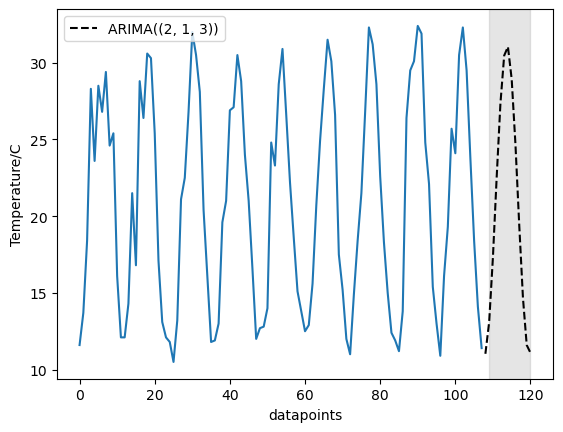

In [16]:
################## forecast future x points ####################################

# future prediction forecast range
x = 12 # next 12 months

# make a df which has this range of values
df['index'] = df.index

# ARIMA predictions
ARIMA_preds = model_fit.get_prediction(len(df),len(df)+x).predicted_mean

test = pd.DataFrame({'arima_pred':ARIMA_preds})

# concat this onto df
df = pd.concat([df,test])

# graph this
fig, ax = plt.subplots()

ax.plot(df.index, df['test'])
ax.plot(df.index, df['arima_pred'], 'k--', label=f"ARIMA({p_use,d,q_use})")

ax.set_xlabel('datapoints')
ax.set_ylabel('Temperature/C')
ax.axvspan(df.index[len(df)-x],df.index[len(df)-1], color='#808080', alpha=0.2)

ax.legend(loc=2);